<a href="https://colab.research.google.com/github/RoloNatt/Patient-Survival-Prediction/blob/main/Patient_Survival_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [256]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
"""
!pip uninstall scikit-learn -y
!pip install scikit-learn==1.1.2
!pip install sklearn
import sklearn.neighbors._base
import sys
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
!pip install missingpy==0.2.0
from missingpy import MissForest
"""
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, 
                            classification_report,
                            roc_auc_score, roc_curve, auc, precision_recall_curve,
                            confusion_matrix)
from xgboost import XGBClassifier



In [184]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [185]:
df = pd.read_csv("Dataset.csv")

In [186]:
dictionary =  pd.read_csv("Data Dictionary.csv")

In [187]:
# Set the option to display all the columns
pd.options.display.max_rows = None

In [188]:
df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [189]:
df.shape

(91713, 186)

In [190]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 186 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   91713 non-null  int64  
 1    patient_id                     91713 non-null  int64  
 2    hospital_id                    91713 non-null  int64  
 3    hospital_death                 91713 non-null  int64  
 4    age                            87485 non-null  float64
 5    bmi                            88284 non-null  float64
 6    elective_surgery               91713 non-null  int64  
 7    ethnicity                      90318 non-null  object 
 8    gender                         91688 non-null  object 
 9    height                         90379 non-null  float64
 10   hospital_admit_source          70304 non-null  object 
 11   icu_admit_source               91601 non-null  object 
 12   icu_id                        

In [191]:
df.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=186)

In [192]:
target_var = 'hospital_death'

In [193]:
# categorical columns
df.describe(include=['O']).T

,count,unique,top,freq
ethnicity,90318,6,Caucasian,70684
gender,91688,2,M,49469
hospital_admit_source,70304,15,Emergency Department,36962
icu_admit_source,91601,5,Accident & Emergency,54060
icu_stay_type,91713,3,admit,86183
icu_type,91713,8,Med-Surg ICU,50586
apache_3j_bodysystem,90051,11,Cardiovascular,29999
apache_2_bodysystem,90051,10,Cardiovascular,38816


In [194]:
# group features in df according to the categories in dictionary
# create a dictionary to map variable names to categories
var_to_cat = dictionary.set_index('Variable Name')['Category'].to_dict()

# group the columns of df1 based on categories
grouped_df1 = df.groupby(var_to_cat, axis=1)

In [195]:
categories = dictionary['Category'].unique()
print(f"Categories: {categories}")

Categories: ['identifier' 'demographic' 'APACHE covariate' 'vitals' 'labs'
 'labs blood gas' 'APACHE prediction' 'APACHE comorbidity'
 'APACHE grouping' 'GOSSIS example prediction']


In [196]:
print('icu_admit_type' in df.columns)

False


In [197]:
"""
# Create new DataFrame for each category
for category in dictionary['Category'].unique():
    category_columns = dictionary.loc[dictionary['Category'] == category, 'Variable Name'].tolist()
    available_columns = list(set(df.columns) & set(category_columns)) # Check which columns are available in df
    available_columns.append(target_var)  # Add hospital_death column to category_columns list
    category_name = category.lower().replace(' ', '_')
    globals()[category_name + '_df'] = df[available_columns].copy()

# Find columns not present in any created dataframes
existing_columns = set()
for category in dictionary['Category'].unique():
    category_name = category.lower().replace(' ', '_')
    existing_columns.update(globals()[category_name + '_df'].columns)
other_columns = set(df.columns) - existing_columns

# Create 'other_df' with columns not present in any created dataframes
other_columns = list(other_columns)
other_columns.append(target_var)  # Add target_var column
other_df = df[other_columns].copy()
"""

"\n# Create new DataFrame for each category\nfor category in dictionary['Category'].unique():\n    category_columns = dictionary.loc[dictionary['Category'] == category, 'Variable Name'].tolist()\n    available_columns = list(set(df.columns) & set(category_columns)) # Check which columns are available in df\n    available_columns.append(target_var)  # Add hospital_death column to category_columns list\n    category_name = category.lower().replace(' ', '_')\n    globals()[category_name + '_df'] = df[available_columns].copy()\n\n# Find columns not present in any created dataframes\nexisting_columns = set()\nfor category in dictionary['Category'].unique():\n    category_name = category.lower().replace(' ', '_')\n    existing_columns.update(globals()[category_name + '_df'].columns)\nother_columns = set(df.columns) - existing_columns\n\n# Create 'other_df' with columns not present in any created dataframes\nother_columns = list(other_columns)\nother_columns.append(target_var)  # Add target_v

In [198]:
"""
category = 'demographic'
category_df = demographic_df
"""

"\ncategory = 'demographic'\ncategory_df = demographic_df\n"

In [199]:
"""
category_rows = dictionary['Category'] == category
category_columns = ['Variable Name', 'Description']
print(dictionary.loc[category_rows, category_columns])
"""

"\ncategory_rows = dictionary['Category'] == category\ncategory_columns = ['Variable Name', 'Description']\nprint(dictionary.loc[category_rows, category_columns])\n"

In [200]:
#category_df.isna().sum()

In [201]:
#category_df.nunique()

In [202]:
"""
# countplot for categorical features
categorical_columns = category_df.select_dtypes(include='object').columns
num_columns = len(categorical_columns)
num_rows = (num_columns + 2) // 3  # Calculate the number of rows needed

for i, col in enumerate(categorical_columns):
    if i % 3 == 0:
        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

    plt.subplot(1, 3, (i % 3) + 1)
    if category_df[col].nunique() <= 50:
        sns.countplot(y=col, data=category_df)
    else:
        sns.countplot(x=col, data=category_df)
        plt.xticks(rotation=90)  # Rotate x-axis labels if needed

    plt.title(f'Countplot: {col}')
    plt.xlabel('Count')

    if i % 3 == 2 or i == num_columns - 1:
        plt.tight_layout()  # Adjust the spacing between subplots
        plt.show()
"""

"\n# countplot for categorical features\ncategorical_columns = category_df.select_dtypes(include='object').columns\nnum_columns = len(categorical_columns)\nnum_rows = (num_columns + 2) // 3  # Calculate the number of rows needed\n\nfor i, col in enumerate(categorical_columns):\n    if i % 3 == 0:\n        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed\n\n    plt.subplot(1, 3, (i % 3) + 1)\n    if category_df[col].nunique() <= 50:\n        sns.countplot(y=col, data=category_df)\n    else:\n        sns.countplot(x=col, data=category_df)\n        plt.xticks(rotation=90)  # Rotate x-axis labels if needed\n\n    plt.title(f'Countplot: {col}')\n    plt.xlabel('Count')\n\n    if i % 3 == 2 or i == num_columns - 1:\n        plt.tight_layout()  # Adjust the spacing between subplots\n        plt.show()\n"

In [203]:
"""
# Check the data types of the columns in category_df
print(category_df.dtypes)
"""

'\n# Check the data types of the columns in category_df\nprint(category_df.dtypes)\n'

In [204]:
"""
# Remove duplicate column 'hospital_death' from the DataFrame
category_df = category_df.loc[:, ~category_df.columns.duplicated()]
"""

"\n# Remove duplicate column 'hospital_death' from the DataFrame\ncategory_df = category_df.loc[:, ~category_df.columns.duplicated()]\n"

In [205]:
#print(category_df.dtypes)

In [206]:
"""
# Count the number of classification columns
classification_columns = category_df.select_dtypes(include='object').columns
num_classification_columns = len(classification_columns)

# Count the number of regression columns
regression_columns = category_df.select_dtypes(exclude='object').columns
num_regression_columns = len(regression_columns)

print("Number of Classification Columns:", num_classification_columns)
print("Number of Regression Columns:", num_regression_columns)
"""

'\n# Count the number of classification columns\nclassification_columns = category_df.select_dtypes(include=\'object\').columns\nnum_classification_columns = len(classification_columns)\n\n# Count the number of regression columns\nregression_columns = category_df.select_dtypes(exclude=\'object\').columns\nnum_regression_columns = len(regression_columns)\n\nprint("Number of Classification Columns:", num_classification_columns)\nprint("Number of Regression Columns:", num_regression_columns)\n'

In [207]:
"""
# Get the regression columns from the DataFrame (excluding the target variable column)
regression_columns = category_df.columns[category_df.dtypes != 'object'].tolist()

num_columns = len(regression_columns)
num_rows = (num_columns + 2) // 3  # Calculate the number of rows needed

# Create histograms for each regression column
for i, column in enumerate(regression_columns):
    if i % 3 == 0:
        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

    plt.subplot(1, 3, (i % 3) + 1)
    #sns.histplot(data=category_df, x=column, hue=target_var, kde=True)
    sns.histplot(data=category_df, x=column, hue=target_var)
    plt.title(f'Histogram: {column} with Hue - Hospital Death')
    plt.xlabel(column)
    plt.ylabel('Count')
    

    if i % 3 == 2 or i == num_columns - 1:
        plt.tight_layout()  # Adjust the spacing between subplots
        plt.show()
"""

"\n# Get the regression columns from the DataFrame (excluding the target variable column)\nregression_columns = category_df.columns[category_df.dtypes != 'object'].tolist()\n\nnum_columns = len(regression_columns)\nnum_rows = (num_columns + 2) // 3  # Calculate the number of rows needed\n\n# Create histograms for each regression column\nfor i, column in enumerate(regression_columns):\n    if i % 3 == 0:\n        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed\n\n    plt.subplot(1, 3, (i % 3) + 1)\n    #sns.histplot(data=category_df, x=column, hue=target_var, kde=True)\n    sns.histplot(data=category_df, x=column, hue=target_var)\n    plt.title(f'Histogram: {column} with Hue - Hospital Death')\n    plt.xlabel(column)\n    plt.ylabel('Count')\n    \n\n    if i % 3 == 2 or i == num_columns - 1:\n        plt.tight_layout()  # Adjust the spacing between subplots\n        plt.show()\n"

In [208]:
"""
# Get the classification columns from the DataFrame (excluding the target variable column)
classification_columns = category_df.columns[category_df.dtypes == 'object'].tolist()
num_columns = len(classification_columns)
num_rows = (num_columns + 2) // 3  # Calculate the number of rows needed

for i, column in enumerate(classification_columns):
    if i % 3 == 0:
        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed

    plt.subplot(1, 3, (i % 3) + 1)
    sns.countplot(data=category_df, x=column, hue=target_var)
    plt.xlabel(column)
    plt.ylabel('Count')
    plt.xticks(rotation=90)

    if i % 3 == 2 or i == num_columns - 1:
        plt.tight_layout()  # Adjust the spacing between subplots
        plt.show() 
"""        

"\n# Get the classification columns from the DataFrame (excluding the target variable column)\nclassification_columns = category_df.columns[category_df.dtypes == 'object'].tolist()\nnum_columns = len(classification_columns)\nnum_rows = (num_columns + 2) // 3  # Calculate the number of rows needed\n\nfor i, column in enumerate(classification_columns):\n    if i % 3 == 0:\n        plt.figure(figsize=(15, 5))  # Adjust the figure size if needed\n\n    plt.subplot(1, 3, (i % 3) + 1)\n    sns.countplot(data=category_df, x=column, hue=target_var)\n    plt.xlabel(column)\n    plt.ylabel('Count')\n    plt.xticks(rotation=90)\n\n    if i % 3 == 2 or i == num_columns - 1:\n        plt.tight_layout()  # Adjust the spacing between subplots\n        plt.show() \n"

In [209]:
"""
#The histogram is created for the "age" column, and the "hospital_death" column is used to color the bars. The "gender" column is used to create separate traces on the histogram, and the "bmi" column is included in the hover data.

fig = px.histogram(category_df[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=category_df[['age','gender','hospital_death','bmi']].columns)
fig.show()
"""

'\n#The histogram is created for the "age" column, and the "hospital_death" column is used to color the bars. The "gender" column is used to create separate traces on the histogram, and the "bmi" column is included in the hover data.\n\nfig = px.histogram(category_df[[\'age\',\'gender\',\'hospital_death\',\'bmi\']].dropna(), x="age", y="hospital_death", color="gender",\n                   marginal="box", # or violin, rug\n                   hover_data=category_df[[\'age\',\'gender\',\'hospital_death\',\'bmi\']].columns)\nfig.show()\n'

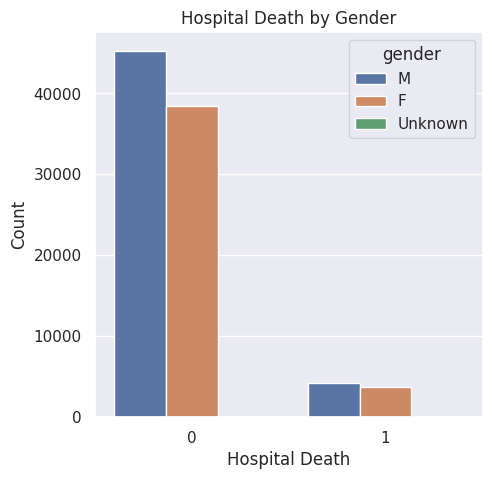

In [210]:

fig, ax = plt.subplots(1, 1, figsize=(5, 5), sharey=True)

temp_df = df.copy(deep=True)

# Handle missing values in the 'gender' column
temp_df['gender'] = temp_df['gender'].fillna('Unknown')

sns.set(style="darkgrid")  # Set the style of the plot

# Create the bar plot
sns.countplot(data=temp_df, x='hospital_death', hue='gender')

# Set the labels and title
plt.xlabel('Hospital Death')
plt.ylabel('Count')
plt.title('Hospital Death by Gender')

# Show the plot
plt.show()

In [211]:
fig = px.histogram(df[['age','gender','hospital_death','bmi']].dropna(), x="age", y="hospital_death", color="gender",
                   marginal="box", # or violin, rug
                   hover_data=df[['age','gender','hospital_death','bmi']].columns)
fig.show()

In [212]:
# average hospital death of patients based on age and gender
age_death_F=df[df['gender']=='F'][['age','hospital_death']].groupby('age').mean().reset_index()
age_death_M=df[df['gender']=='M'][['age','hospital_death']].groupby('age').mean().reset_index()

fig = make_subplots()
fig.add_trace(
    go.Scatter(x=age_death_F['age'], y=age_death_F['hospital_death'], name="Female patients"))
fig.add_trace(
    go.Scatter(x=age_death_M['age'], y=age_death_M['hospital_death'],name="Male patients"))
fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient age<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

In [213]:
# average hospital death of patients based on height
height_death=df[['height','hospital_death']].groupby('height').mean().reset_index()
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=height_death['height'], y=height_death['hospital_death']))

fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient height<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

In [214]:
# average hospital death of patients based on weight
weight_death=df[['weight','hospital_death']].groupby('weight').mean().reset_index()
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=weight_death['weight'], y=weight_death['hospital_death']))

fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient weight<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

In [215]:
# average hospital death of patients based on bmi
bmi_death=df[['bmi','hospital_death']].groupby('bmi').mean().reset_index()
fig = make_subplots()
fig.add_trace(
    go.Scatter(x=bmi_death['bmi'], y=bmi_death['hospital_death']))

fig.update_layout(
    title_text="<b>Average hospital death probability of patients<b>")
fig.update_xaxes(title_text="<b>patient bmi<b>")
fig.update_yaxes(title_text="<b>Average Hospital Death</b>", secondary_y=False)
fig.show()

In [216]:
df2 = df.copy(deep=True)

In [217]:
df2.shape

(91713, 186)

In [218]:
df2.isna().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
hospital_death                       0
age                               4228
bmi                               3429
elective_surgery                     0
ethnicity                         1395
gender                              25
height                            1334
hospital_admit_source            21409
icu_admit_source                   112
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
readmission_status                   0
weight                            2720
albumin_apache                   54379
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
apache_post_operative                0
arf_apache                         715
bilirubin_apache                 58134
bun_apache                       19262
creatinine_apache        

In [219]:
# drop all columns that have more than 60% NaN values
threshold = len(df2) * 0.6  # Calculate the threshold

# Filter columns with NaN values exceeding the threshold
columns_to_drop = df2.columns[df2.isna().sum() > threshold]

# Drop the columns from the DataFrame
df2 = df2.drop(columns=columns_to_drop)


In [220]:
df2.isna().sum()

encounter_id                         0
patient_id                           0
hospital_id                          0
hospital_death                       0
age                               4228
bmi                               3429
elective_surgery                     0
ethnicity                         1395
gender                              25
height                            1334
hospital_admit_source            21409
icu_admit_source                   112
icu_id                               0
icu_stay_type                        0
icu_type                             0
pre_icu_los_days                     0
readmission_status                   0
weight                            2720
albumin_apache                   54379
apache_2_diagnosis                1662
apache_3j_diagnosis               1101
apache_post_operative                0
arf_apache                         715
bun_apache                       19262
creatinine_apache                18853
gcs_eyes_apache          

In [221]:
df2.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 120 columns):
 #    Column                         Non-Null Count  Dtype  
---   ------                         --------------  -----  
 0    encounter_id                   91713 non-null  int64  
 1    patient_id                     91713 non-null  int64  
 2    hospital_id                    91713 non-null  int64  
 3    hospital_death                 91713 non-null  int64  
 4    age                            87485 non-null  float64
 5    bmi                            88284 non-null  float64
 6    elective_surgery               91713 non-null  int64  
 7    ethnicity                      90318 non-null  object 
 8    gender                         91688 non-null  object 
 9    height                         90379 non-null  float64
 10   hospital_admit_source          70304 non-null  object 
 11   icu_admit_source               91601 non-null  object 
 12   icu_id                        

In [222]:
df2.columns

Index(['encounter_id', 'patient_id', 'hospital_id', 'hospital_death', 'age',
       'bmi', 'elective_surgery', 'ethnicity', 'gender', 'height',
       ...
       'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure',
       'immunosuppression', 'leukemia', 'lymphoma',
       'solid_tumor_with_metastasis', 'apache_3j_bodysystem',
       'apache_2_bodysystem'],
      dtype='object', length=120)

In [223]:
df2 = df2.drop(['encounter_id', 'patient_id', 'hospital_id', 'icu_admit_source', 'icu_id', 'icu_stay_type', 'icu_type'], axis=1)   

In [224]:
# Fill null values in 'bmi' from 'height' and 'weight'
df2['bmi'] = df2['bmi'].fillna(df2['height'] / ((df2['weight'] / 100) ** 2))

In [225]:
# drop height and weight columns
df2 = df2.drop(['weight', 'height'], axis=1)

In [226]:
# drop rows that have null values in 'bmi'
df2 = df2.dropna(subset=['bmi']) 

In [227]:
# Identify numerical and categorical columns
numerical_cols = df2.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df2.select_dtypes(include='object').columns.tolist()

# Perform mean imputation on numerical columns
mean_imputer = SimpleImputer(strategy='mean')
df2[numerical_cols] = mean_imputer.fit_transform(df2[numerical_cols])

# Perform mode imputation on categorical columns
mode_imputer = SimpleImputer(strategy='most_frequent')
df2[categorical_cols] = mode_imputer.fit_transform(df2[categorical_cols])

In [228]:
# PERFORM ONE HOT ENCODING (BINARY ENCODING)
# Select the categorical columns
categorical_columns = df2.select_dtypes(include=['object']).columns

# Perform one-hot encoding
df2 = pd.get_dummies(df2, columns=categorical_columns)

In [229]:
"""
# Get the numeric columns
numeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns

# Convert numeric columns to smaller data types
for column in numeric_columns:
    df2[column] = pd.to_numeric(df2[column], downcast='integer')

# Display the updated data types of the DataFrame
print(df2.dtypes)
"""

"\n# Get the numeric columns\nnumeric_columns = df2.select_dtypes(include=['int64', 'float64']).columns\n\n# Convert numeric columns to smaller data types\nfor column in numeric_columns:\n    df2[column] = pd.to_numeric(df2[column], downcast='integer')\n\n# Display the updated data types of the DataFrame\nprint(df2.dtypes)\n"

In [230]:
"""
# Get the column names with 64-bit data type
int64_columns = df2.select_dtypes(include='int64').columns
float64_columns = df2.select_dtypes(include='float64').columns

# Convert int64 columns to int32
df2[int64_columns] = df2[int64_columns].astype('int32')

# Convert float64 columns to float32
df2[float64_columns] = df2[float64_columns].astype('float32')
"""

"\n# Get the column names with 64-bit data type\nint64_columns = df2.select_dtypes(include='int64').columns\nfloat64_columns = df2.select_dtypes(include='float64').columns\n\n# Convert int64 columns to int32\ndf2[int64_columns] = df2[int64_columns].astype('int32')\n\n# Convert float64 columns to float32\ndf2[float64_columns] = df2[float64_columns].astype('float32')\n"

In [231]:
# Separate dataset into train and test
x = df2.drop(target_var, axis=1)
y = df2[target_var]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [232]:
"""
# PERFORM IMPUTATION OF MISSING VALUES USING MissForest
missing_columns = [x for x in x_train.isna().sum()[x_train.isna().sum() != 0].index.tolist()]

missing_data = x_train[missing_columns].copy()
imputer = MissForest()
imputed_data = imputer.fit_transform(missing_data)
x_train[missing_columns] = imputed_data
"""

'\n# PERFORM IMPUTATION OF MISSING VALUES USING MissForest\nmissing_columns = [x for x in x_train.isna().sum()[x_train.isna().sum() != 0].index.tolist()]\n\nmissing_data = x_train[missing_columns].copy()\nimputer = MissForest()\nimputed_data = imputer.fit_transform(missing_data)\nx_train[missing_columns] = imputed_data\n'

In [233]:
"""# Create an instance of the KNNImputer with the desired number of neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Perform KNN imputation on x_train
x_train = knn_imputer.fit_transform(x_train)
"""

'# Create an instance of the KNNImputer with the desired number of neighbors\nknn_imputer = KNNImputer(n_neighbors=5)\n\n# Perform KNN imputation on x_train\nx_train = knn_imputer.fit_transform(x_train)\n'

In [234]:
"""
x_train.to_csv('x_train.csv', index=False)
x_test.to_csv('x_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)
"""

"\nx_train.to_csv('x_train.csv', index=False)\nx_test.to_csv('x_test.csv', index=False)\ny_train.to_csv('y_train.csv', index=False)\ny_test.to_csv('y_test.csv', index=False)\n"

In [235]:
x_train.shape

(61798, 149)

In [236]:
type(x_train)

pandas.core.frame.DataFrame

In [241]:
import keras
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(500, input_dim=149, activation='relu'))
model.add(Dense(520, activation='relu'))
model.add(Dense(260, activation='relu'))
model.add(Dense(130, activation='relu'))
model.add(Dense(65, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [242]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(learning_rate=0.001)

In [243]:
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

In [244]:
history = model.fit(x_train, y_train,validation_data=(x_test,y_test), epochs=100, batch_size=64)

Epoch 1/100
966/966 [==============================] - 13s 10ms/step - loss: 0.5752 - accuracy: 0.9033 - val_loss: 0.2410 - val_accuracy: 0.9187
Epoch 2/100
966/966 [==============================] - 6s 6ms/step - loss: 0.2465 - accuracy: 0.9166 - val_loss: 0.2413 - val_accuracy: 0.9124
Epoch 3/100
966/966 [==============================] - 5s 5ms/step - loss: 0.2327 - accuracy: 0.9182 - val_loss: 0.2553 - val_accuracy: 0.9178
Epoch 4/100
966/966 [==============================] - 6s 7ms/step - loss: 0.2283 - accuracy: 0.9196 - val_loss: 0.2181 - val_accuracy: 0.9233
Epoch 5/100
966/966 [==============================] - 5s 5ms/step - loss: 0.2229 - accuracy: 0.9199 - val_loss: 0.2171 - val_accuracy: 0.9223
Epoch 6/100
966/966 [==============================] - 6s 6ms/step - loss: 0.2191 - accuracy: 0.9214 - val_loss: 0.2391 - val_accuracy: 0.9224
Epoch 7/100
966/966 [==============================] - 6s 6ms/step - loss: 0.2163 - accuracy: 0.9214 - val_loss: 0.2079 - val_accuracy: 0.92

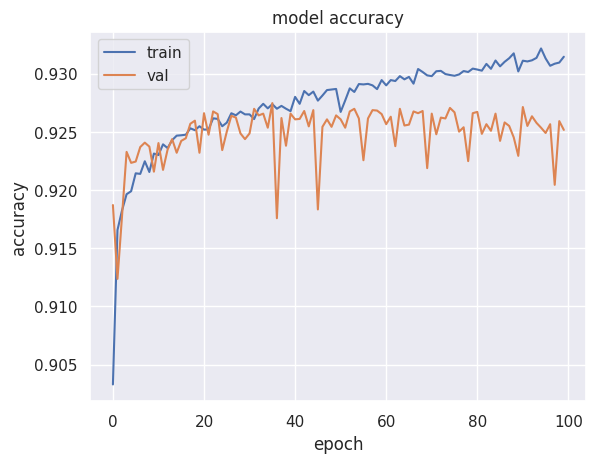

In [245]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

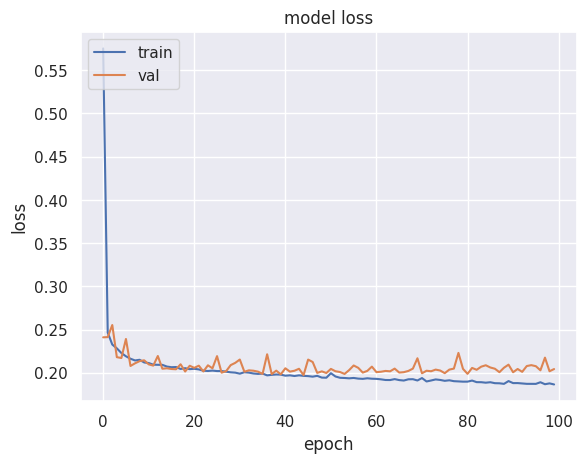

In [246]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [247]:
model.save('deep_model_patient_survival')

In [250]:
def model_performance(model, y_test, y_hat) : 
    conf_matrix = confusion_matrix(y_test, y_hat)
    trace1 = go.Heatmap(z = conf_matrix  ,x = ["0 (pred)","1 (pred)"],
                        y = ["0 (true)","1 (true)"],xgap = 2, ygap = 2, 
                        colorscale = 'Viridis', showscale  = False)

    #Show metrics
    tp = conf_matrix[1,1]
    fn = conf_matrix[1,0]
    fp = conf_matrix[0,1]
    tn = conf_matrix[0,0]
    Accuracy  =  ((tp+tn)/(tp+tn+fp+fn))
    Precision =  (tp/(tp+fp))
    Recall    =  (tp/(tp+fn))
    F1_score  =  (2*(((tp/(tp+fp))*(tp/(tp+fn)))/((tp/(tp+fp))+(tp/(tp+fn)))))

    show_metrics = pd.DataFrame(data=[[Accuracy , Precision, Recall, F1_score]])
    show_metrics = show_metrics.T

    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = (show_metrics[0].values), 
                   y = ['Accuracy', 'Precision', 'Recall', 'F1_score'], text = np.round_(show_metrics[0].values,4),
                    textposition = 'auto',
                   orientation = 'h', opacity = 0.8,marker=dict(
            color=colors,
            line=dict(color='#000000',width=1.5)))
    
    #Roc curve
    model_roc_auc = round(roc_auc_score(y_test, y_hat) , 3)
    fpr, tpr, t = roc_curve(y_test, y_hat)
    trace3 = go.Scatter(x = fpr,y = tpr,
                        name = "Roc : " + str(model_roc_auc),
                        line = dict(color = ('rgb(22, 96, 167)'),width = 2), fill='tozeroy')
    trace4 = go.Scatter(x = [0,1],y = [0,1],
                        line = dict(color = ('black'),width = 1.5,
                        dash = 'dot'))
    
    # Precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, y_hat)
    trace5 = go.Scatter(x = recall, y = precision,
                        name = "Precision" + str(precision),
                        line = dict(color = ('lightcoral'),width = 2), fill='tozeroy')
    
     
    #plots
    model = model
    
    #Subplots
    fig = tls.make_subplots(rows=2, cols=2, print_grid=False, 
                          specs=[ 
#                               [{'colspan': 2}, None],
                                 [{}, {}],
                                 [{}, {}],
                                 
#                                  [{'colspan': 2}, None]
                                ],
                          subplot_titles=('Confusion Matrix',
                                        'Metrics',
                                        'ROC curve'+" "+ '('+ str(model_roc_auc)+')',
                                        'Precision - Recall curve',
                                        ))
    
    fig.append_trace(trace1,1,1)
    fig.append_trace(trace2,1,2)
    fig.append_trace(trace3,2,1)
    fig.append_trace(trace4,2,1)
    fig.append_trace(trace5,2,2)
    
    fig['layout'].update(showlegend = False, title = '<b>Model performance report</b><br>'+str(model),
                        autosize = False, height = 1500,width = 830,
                        plot_bgcolor = 'rgba(240,240,240, 0.95)',
                        paper_bgcolor = 'rgba(240,240,240, 0.95)',
                        margin = dict(b = 195))
#     fig["layout"]["xaxis2"].update((dict(range=[0, 1])))
#     fig["layout"]["xaxis3"].update(dict(title = "false positive rate"))
#     fig["layout"]["yaxis3"].update(dict(title = "true positive rate"))
#     fig["layout"]["xaxis4"].update(dict(title = "recall"), range = [0,1.05])
#     fig["layout"]["yaxis4"].update(dict(title = "precision"), range = [0,1.05])
#     fig["layout"]["xaxis5"].update(dict(title = "Percentage contacted"))
#     fig["layout"]["yaxis5"].update(dict(title = "Percentage positive targeted"))
    fig.layout.titlefont.size = 14
    
    py.iplot(fig)

In [252]:
# Parameter Tuning
gkf = KFold(n_splits=3, shuffle=True, random_state=42).split(X=x_train, y=y_train)

fit_params_of_xgb = {
    "early_stopping_rounds":100, 
    "eval_metric" : 'auc', 
    "eval_set" : [(x_test, y_test)],
    'verbose': 100,
}


# A parameter grid for XGBoost
params = {
    'booster': ["gbtree"],
    'learning_rate': [0.1],
    'n_estimators': range(100, 500, 100),
    'min_child_weight': [1],
    'gamma': [0],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'max_depth': [5],
    "scale_pos_weight": [1]
}

xgb_estimator = XGBClassifier(
    objective='binary:logistic',
    # silent=True,
)

gsearch = GridSearchCV(
    estimator=xgb_estimator,
    param_grid=params,
    scoring='roc_auc',
    n_jobs=-1,
    cv=gkf
)

xgb_model = gsearch.fit(X=x_train, y=y_train, **fit_params_of_xgb)
(gsearch.best_params_, gsearch.best_score_)

[0]	validation_0-auc:0.84222
[100]	validation_0-auc:0.89303
[199]	validation_0-auc:0.89636


({'booster': 'gbtree',
  'colsample_bytree': 0.8,
  'gamma': 0,
  'learning_rate': 0.1,
  'max_depth': 5,
  'min_child_weight': 1,
  'n_estimators': 200,
  'scale_pos_weight': 1,
  'subsample': 0.8},
 0.8951040131870801)

In [253]:
# final model evaluation
xgb_tuned = XGBClassifier(n_estimators=3000,
    objective='binary:logistic',
    booster="gbtree",
    learning_rate=0.01,
    scale_pos_weight=1,
    max_depth=4,
    min_child_weight=6,
    gamma=0,
    subsample=0.4,
    colsample_bytree=0.8,
    reg_alpha=0.08,
    n_jobs=-1)

xgb_tuned.fit(x_train._get_numeric_data(), np.ravel(y_train, order='C'))
y__hat = xgb_tuned.predict(x_test._get_numeric_data())

In [257]:
model_performance(xgb_tuned,y_test, y__hat)